# Tailored constraints, variables and objectives

Thanks to the use of symbolic expressions via the optlang mathematical modeling package, it is relatively straight-forward to add new variables, constraints and advanced objectives that can not easily be formulated as a combination of different reaction and their corresponding upper and lower bounds. Here we demonstrate this optlang functionality which is exposed via the `model.solver.interface`.

## Constraints

Suppose we want to ensure that two reactions have the same flux in our model. We can add this criteria as constraint to our model using the optlang solver interface by simply defining the relevant expression as follows.

In [1]:
import cobra.test
model = cobra.test.create_test_model('textbook')

/home/moritz/.virtualenvs/cobra/lib/python3.5/site-packages/optlang/gurobi_interface.py:26: UserWarning: Be careful! The GUROBI interface is still under construction ...
  warn("Be careful! The GUROBI interface is still under construction ...")


In [2]:
same_flux = model.problem.Constraint(
    model.reactions.FBA.flux_expression - model.reactions.NH4t.flux_expression,
    lb=0,
    ub=0)
model.add_cons_vars(same_flux)

The flux for our reaction of interest is obtained by the `model.reactions.FBA.flux_expression` which is simply the sum of the forward and reverse flux, i.e.,

In [3]:
model.reactions.FBA.flux_expression

1.0*FBA - 1.0*FBA_reverse_84806

Now I can maximize growth rate whilst the fluxes of reactions 'FBA' and 'NH4t' are constrained to be (near) identical.

In [4]:
solution = model.optimize()
print(solution.fluxes['FBA'], solution.fluxes['NH4t'],
      solution.objective_value)

4.66274904774 4.66274904774 0.855110960926157


## Objectives




Simple objective such as the maximization of the flux through one or more reactions can conveniently be done by simply 
assigning to the `model.objective` property as we have seen in previous chapters, e.g.,

In [5]:
model = cobra.test.create_test_model('textbook')
with model:
    model.objective = {model.reactions.Biomass_Ecoli_core: 1}
    model.optimize()
    print(model.reactions.Biomass_Ecoli_core.flux)

0.8739215069684307


The objectives mathematical expression is seen by

In [6]:
model.objective.expression

-1.0*Biomass_Ecoli_core_reverse_2cdba + 1.0*Biomass_Ecoli_core

But suppose we need a more complicated objective, such as minimizing the Euclidean distance of the solution to the origin minus another variable, while subject to additional linear constraints. This is an objective function with both linear and quadratic components. 

Consider the example problem:

> **min** $\frac{1}{2}\left(x^2 + y^2 \right) - y$

> *subject to*

> $x + y = 2$

> $x \ge 0$

> $y \ge 0$

This (admittedly very artificial) problem can be visualized graphically where the optimum is indicated by the blue dot on the line of feasible solutions.

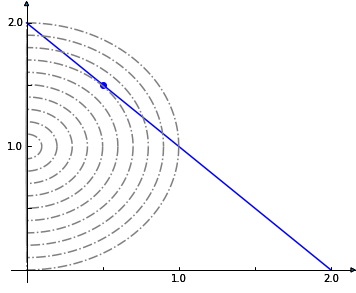

In [7]:
%matplotlib inline
import plot_helper

plot_helper.plot_qp2()

We return to the textbook model and set the solver to one that can handle quadratic objectives such as cplex. We then add the linear constraint that the sum of our x and y reactions, that we set to FBA and NH4t, must equal 2.

In [8]:
model.solver = 'cplex'
sum_two = model.problem.Constraint(
    model.reactions.FBA.flux_expression + model.reactions.NH4t.flux_expression,
    lb=2,
    ub=2)
model.add_cons_vars(sum_two)

Next we add the quadratic objective

In [9]:
quadratic_objective = model.problem.Objective(
    0.5 * model.reactions.NH4t.flux_expression**2 + 0.5 *
    model.reactions.FBA.flux_expression**2 -
    model.reactions.FBA.flux_expression,
    direction='min')
model.objective = quadratic_objective
solution = model.optimize(objective_sense=None)

In [10]:
print(solution.fluxes['NH4t'], solution.fluxes['FBA'])

0.5 1.5


## Variables

We can also create additional variables to facilitate studying the effects of new constraints and variables. Suppose we want to study the difference in flux between nitrogen and carbon uptake whilst we block other reactions. For this it will may help to add another variable representing this difference.

In [11]:
model = cobra.test.create_test_model('textbook')
difference = model.problem.Variable('difference')

We use constraints to define what values this variable shall take

In [12]:
constraint = model.problem.Constraint(
    model.reactions.EX_glc__D_e.flux_expression -
    model.reactions.EX_nh4_e.flux_expression - difference,
    lb=0,
    ub=0)
model.add_cons_vars([difference, constraint])

Now we can access that difference directly during our knock-out exploration by looking at its primal value.

In [13]:
for reaction in model.reactions[:5]:
    with model:
        reaction.knock_out()
        model.optimize()
        print(model.solver.variables.difference.primal)

-5.234680806802543
-5.2346808068025386
-5.234680806802525
-1.8644444444444337
-1.8644444444444466
